In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score



In [2]:
from helper_functions import check_dir_exists, load_n_samples, load_balanced_n_samples, convert_labels

In [3]:
def init_results_dict():

        nested_dict = {
                'balanced': {
                        'balanced': {},
                        'unbalanced': {},
                },
                'unbalanced': {
                        'balanced': {},
                        'unbalanced': {},
                },
        }

        model_dict = {
                'MultinomialNB': nested_dict,
                'ComplementNB': nested_dict,
                'MultinomialNB+log': nested_dict,
                'ComplementNB+log': nested_dict,
        }

        results_dict = {}
        results_dict['binary_movie_sentiment'] = model_dict
        results_dict['binary_abuse'] = model_dict

        return results_dict

def log_transform(tfidf_matrix):
    return np.log1p(tfidf_matrix.toarray())  # log(1 + x)

def make_pipeline_from_string(model_string):
    if model_string == "MultinomialNB":
        model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    elif model_string == "ComplementNB":
        model = make_pipeline(TfidfVectorizer(), ComplementNB())
    elif model_string == "MultinomialNB+log":
        model = make_pipeline(TfidfVectorizer(), FunctionTransformer(log_transform, validate=False), MultinomialNB())
    elif model_string == "ComplementNB+log":
        model = make_pipeline(TfidfVectorizer(), FunctionTransformer(log_transform, validate=False), ComplementNB())
    else:
        print("No correct string")
    
    return model

In [4]:
balanced_train = True
balanced_eval = True
TASK = 'binary_movie_sentiment'
data_dir = '../data'
eval_set = 'dev_sample'
n_eval = -1



In [5]:
seeds = [1, 2, 3]
budgets = [16, 32, 64, 128, 256, 514, 1024]
models = ['Multinomial NB', 'Complement NB', 'Multinomial NB \n + log weighting', 'Complement NB \n+ log weighting']

In [108]:


over_predictions_dict = {
    'True': [over_predictions[model, :, 1].mean() for model in range(4)],
    'False': [over_predictions[model, :, 0].mean() for model in range(4)]
}

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in over_predictions_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Overprediction (% of total answers)')
ax.set_title('Overprediction of Naive Bayes Classifier')
ax.set_xticks(x + width, models)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='upper left', ncols=3)
plt.ylim(0, 20)

plt.grid(alpha=0.3)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [7]:
seeds = range(3)
results_dict_binary_abuse = init_results_dict()

data_dict_binary_abuse = init_results_dict()

task = "binary_abuse"

#for task in ["binary_abuse", "binary_movie_sentiment"]:
for (idx_model, m) in enumerate(models):
    model_str = m.replace(" ", "").replace("\n", "").replace("weighting", "")

    for balanced_train, train in [(False, 'unbalanced'), (True, 'balanced')]:
        for balanced_eval, eval in [(False, 'unbalanced'), (True, 'balanced')]:
            
            f1_macros = np.zeros((len(seeds), len(budgets)))
            over_predictions = np.zeros((len(seeds), len(budgets)))
            
            for (j, n_train) in tqdm(enumerate(budgets)):
                # Prepare dataset
                for (i, seed) in enumerate(seeds):
                    raw_dataset = {}
                    if balanced_train is False:
                        if task == 'binary_movie_sentiment' :
                            random.seed(seed)
                            filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
                            n = sum(1 for line in open(filename)) - 1
                            skip = sorted(random.sample(range(1, n + 1), n - n_train))
                            df = pd.read_csv(filename, skiprows=skip)
                            raw_dataset['train'], n_classes_train = convert_labels(df)
                        else:
                            raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                                    seed=seed))
                    else:
                        raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                                        n_train, seed=seed))
                    balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
                    final_eval_set = balanced_eval_suffix + eval_set
                    raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

                    if n_train == budgets[-1]:
                        data_dict_binary_abuse[task][model_str][train][eval][f"seed_{i}"] = raw_dataset['train']

                    model = make_pipeline_from_string(model_str)
                    model.fit(raw_dataset['train']['text'], raw_dataset['train']['label'])
                    predicted_labels = model.predict(raw_dataset['eval']['text'])
                    f1_macros[i, j] = f1_score(raw_dataset['eval']['label'], predicted_labels, average="macro", zero_division=0)

                    if n_train == budgets[-1]:
                        total = len(predicted_labels)
                        df = pd.DataFrame(data={'predictions': predicted_labels, 'ground_truth': raw_dataset['eval']['label']})
                        over_predictions[i, 0] = len(df.loc[(df.ground_truth==1) & (df.predictions==0)])*100/total
                        over_predictions[i, 1] = len(df.loc[(df.ground_truth==0) & (df.predictions==1)])*100/total
                        
            print(f"Saving for : {task}, {model_str}, {train} {eval}")
            results_dict_binary_abuse[task][model_str][train][eval]['f1_macro'] = f1_macros
            results_dict_binary_abuse[task][model_str][train][eval]['over_predictions'] = over_predictions
print(f"{task} done")
            


7it [00:04,  1.73it/s]


Saving for : binary_abuse, MultinomialNB, unbalanced unbalanced


7it [00:03,  1.81it/s]


Saving for : binary_abuse, MultinomialNB, unbalanced balanced


7it [00:06,  1.03it/s]


Saving for : binary_abuse, MultinomialNB, balanced unbalanced


7it [00:06,  1.07it/s]


Saving for : binary_abuse, MultinomialNB, balanced balanced


7it [00:04,  1.68it/s]


Saving for : binary_abuse, ComplementNB, unbalanced unbalanced


7it [00:03,  1.78it/s]


Saving for : binary_abuse, ComplementNB, unbalanced balanced


7it [00:06,  1.04it/s]


Saving for : binary_abuse, ComplementNB, balanced unbalanced


7it [00:06,  1.05it/s]


Saving for : binary_abuse, ComplementNB, balanced balanced


7it [00:05,  1.27it/s]


Saving for : binary_abuse, MultinomialNB+log, unbalanced unbalanced


7it [00:05,  1.34it/s]


Saving for : binary_abuse, MultinomialNB+log, unbalanced balanced


7it [00:08,  1.17s/it]


Saving for : binary_abuse, MultinomialNB+log, balanced unbalanced


7it [00:08,  1.16s/it]


Saving for : binary_abuse, MultinomialNB+log, balanced balanced


7it [00:05,  1.24it/s]


Saving for : binary_abuse, ComplementNB+log, unbalanced unbalanced


7it [00:05,  1.30it/s]


Saving for : binary_abuse, ComplementNB+log, unbalanced balanced


7it [00:08,  1.17s/it]


Saving for : binary_abuse, ComplementNB+log, balanced unbalanced


7it [00:07,  1.08s/it]

Saving for : binary_abuse, ComplementNB+log, balanced balanced
binary_abuse done


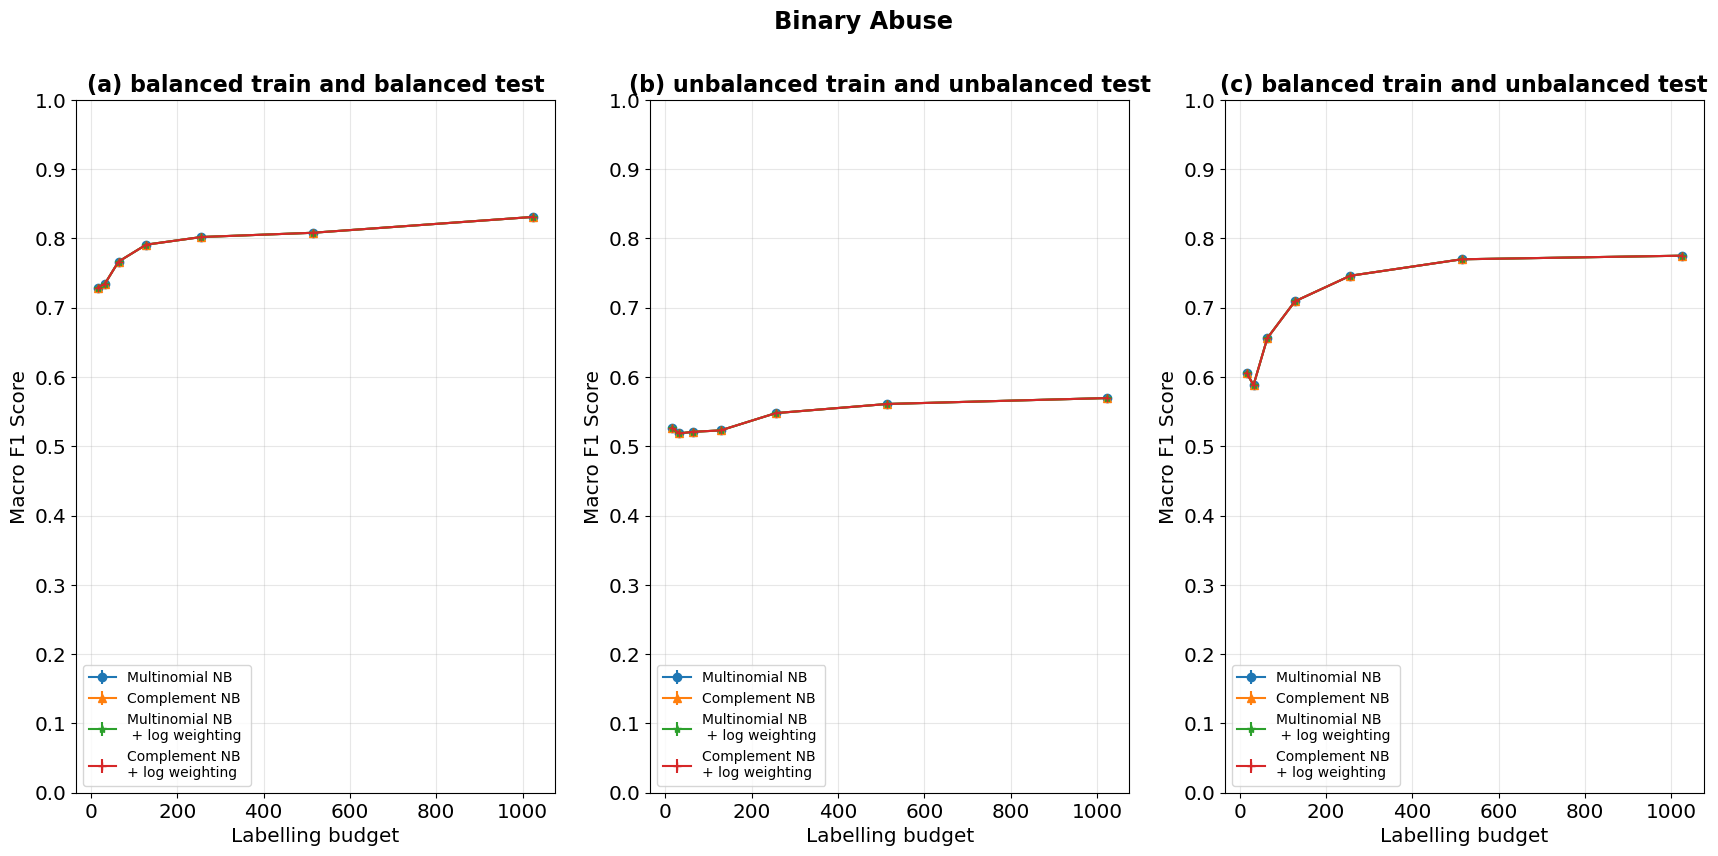

In [75]:
task = "binary_abuse"
fig, axes = plt.subplots(1, 3, figsize=(21, 9))

fmts = ['o', '^', '*', '+']

fig.suptitle(task.replace("_", " ").title(), fontsize='xx-large', fontweight='semibold')
for (idx_model, model) in enumerate(models):
    model_str = model.replace(" ", "").replace("\n", "").replace("weighting", "")
    axes[0].errorbar(x=budgets, y=results_dict_binary_abuse[task][model_str]["balanced"]["balanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_binary_abuse[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)
    axes[1].errorbar(x=budgets, y=results_dict_binary_abuse[task][model_str]["unbalanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_binary_abuse[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)
    axes[2].errorbar(x=budgets, y=results_dict_binary_abuse[task][model_str]["balanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_binary_abuse[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)

for i in range(3):
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim((0., 1))
    axes[i].set_ylabel("Macro F1 Score", size='x-large')
    axes[i].set_xlabel("Labelling budget", size='x-large')
    axes[i].set_yticks(np.linspace(0, 1, 11))
    axes[i].tick_params(axis='both', which='major', labelsize='x-large')
    axes[i].legend(loc=3)


axes[0].set_title("(a) balanced train and balanced test", fontweight = 'semibold', fontsize = 16)
axes[1].set_title("(b) unbalanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)
axes[2].set_title("(c) balanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)

plt.savefig("naive_bayes_binary_abuse.png", format="png", bbox_inches="tight")

In [9]:
seeds = range(10)
results_dict_movie_sentiment = init_results_dict()

data_dict_movie_sentiment = init_results_dict()

task = "binary_movie_sentiment"

#for task in ["binary_abuse", "binary_movie_sentiment"]:
for (idx_model, m) in tqdm(enumerate(models)):
    model_str = m.replace(" ", "").replace("\n", "").replace("weighting", "")

    for balanced_train, train in [(False, 'unbalanced'), (True, 'balanced')]:
        for balanced_eval, eval in [(False, 'unbalanced'), (True, 'balanced')]:
            
            f1_macros = np.zeros((len(seeds), len(budgets)))
            over_predictions = np.zeros((len(seeds), len(budgets)))
            
            for (j, n_train) in enumerate(budgets):
                # Prepare dataset
                for (i, seed) in enumerate(seeds):
                    raw_dataset = {}
                    if balanced_train is False:
                        if task == 'binary_movie_sentiment' :
                            random.seed(seed)
                            filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
                            n = sum(1 for line in open(filename)) - 1
                            skip = sorted(random.sample(range(1, n + 1), n - n_train))
                            df = pd.read_csv(filename, skiprows=skip)
                            raw_dataset['train'], n_classes_train = convert_labels(df)
                        else:
                            raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                                    seed=seed))
                    else:
                        raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                                        n_train, seed=seed))
                    balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
                    final_eval_set = balanced_eval_suffix + eval_set
                    raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

                    if n_train == budgets[-1]:
                        data_dict_movie_sentiment[task][model_str][train][eval][f"seed_{i}"] = raw_dataset['train']

                    model = make_pipeline_from_string(model_str)
                    model.fit(raw_dataset['train']['text'], raw_dataset['train']['label'])
                    predicted_labels = model.predict(raw_dataset['eval']['text'])
                    f1_macros[i, j] = f1_score(raw_dataset['eval']['label'], predicted_labels, average="macro", zero_division=0)

                    if n_train == budgets[-1]:
                        total = len(predicted_labels)
                        df = pd.DataFrame(data={'predictions': predicted_labels, 'ground_truth': raw_dataset['eval']['label']})
                        over_predictions[i, 0] = len(df.loc[(df.ground_truth==1) & (df.predictions==0)])*100/total
                        over_predictions[i, 1] = len(df.loc[(df.ground_truth==0) & (df.predictions==1)])*100/total
                        
            #print(f"Saving for : {task}, {model_str}, {train} {eval}")
            results_dict_movie_sentiment[task][model_str][train][eval]['f1_macro'] = f1_macros
            results_dict_movie_sentiment[task][model_str][train][eval]['over_predictions'] = over_predictions
print(f"{task} done")
                


4it [04:44, 71.14s/it]

binary_movie_sentiment done


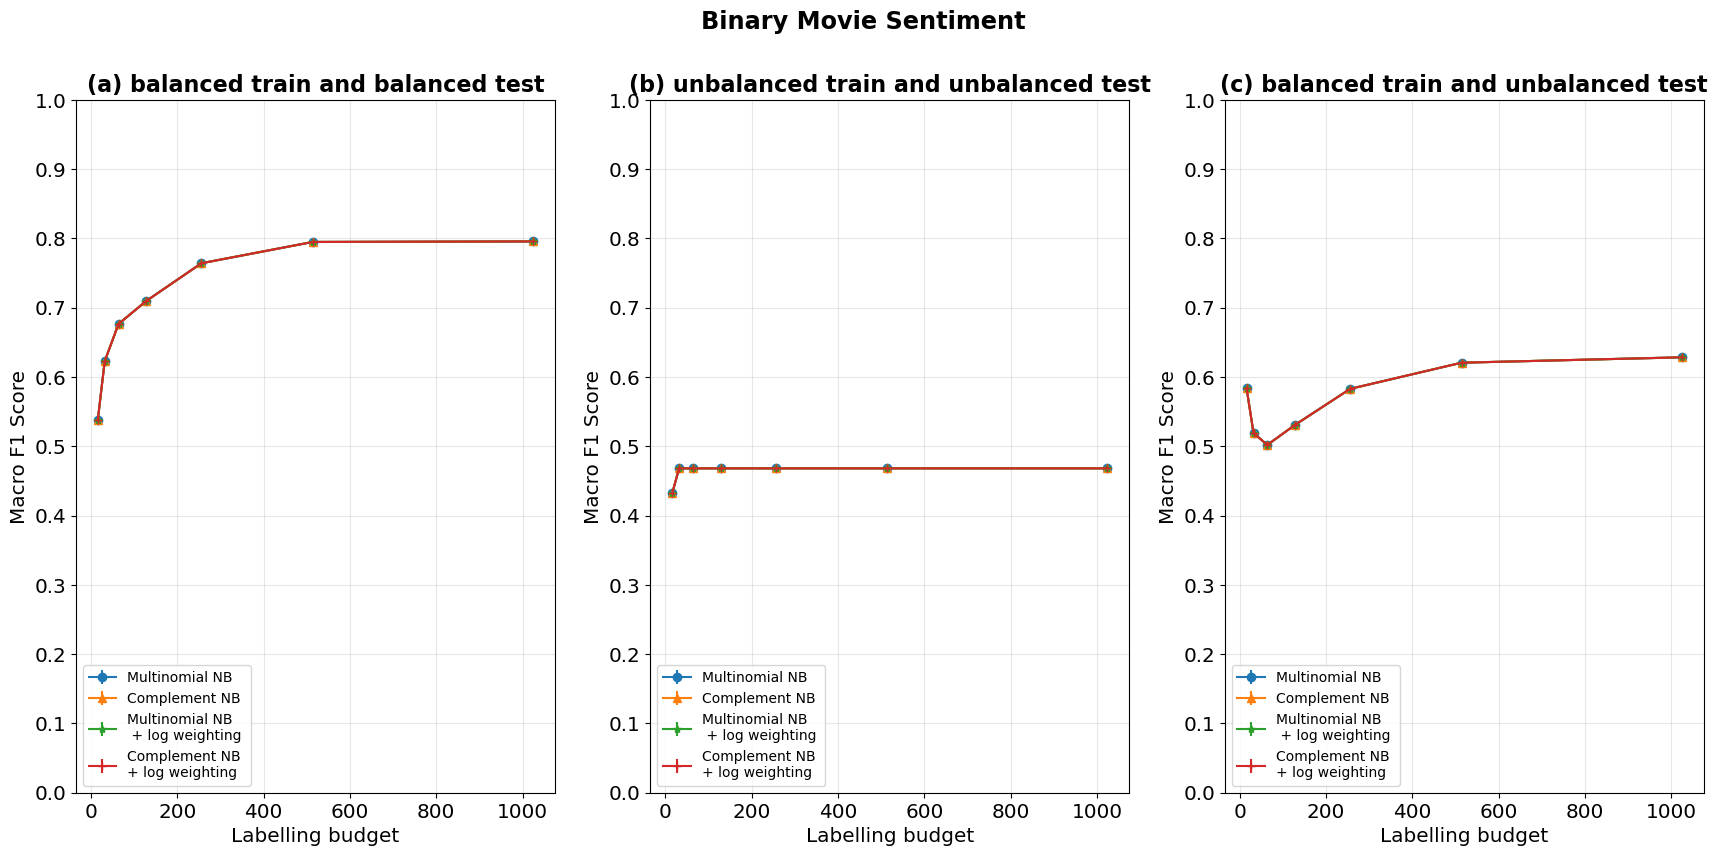

In [73]:
task = "binary_movie_sentiment"

fig, axes = plt.subplots(1, 3, figsize=(21, 9))

fmts = ['o', '^', '*', '+']

fig.suptitle(task.replace("_", " ").title(), fontsize='xx-large', fontweight='semibold')
for (idx_model, model) in enumerate(models):
    model_str = model.replace(" ", "").replace("\n", "").replace("weighting", "")
    axes[0].errorbar(x=budgets, y=results_dict_movie_sentiment[task][model_str]["balanced"]["balanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_movie_sentiment[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)
    axes[1].errorbar(x=budgets, y=results_dict_movie_sentiment[task][model_str]["unbalanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_movie_sentiment[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)
    axes[2].errorbar(x=budgets, y=results_dict_movie_sentiment[task][model_str]["balanced"]["unbalanced"]["f1_macro"].mean(axis=0), 
                    yerr=results_dict_movie_sentiment[task][model_str]["balanced"]["balanced"]["f1_macro"].std(axis=0),
                    marker=fmts[idx_model], label=model)

for i in range(3):
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim((0., 1))
    axes[i].set_ylabel("Macro F1 Score", size='x-large')
    axes[i].set_xlabel("Labelling budget", size='x-large')
    axes[i].set_yticks(np.linspace(0, 1, 11))
    axes[i].tick_params(axis='both', which='major', labelsize='x-large')
    axes[i].legend(loc=3)


axes[0].set_title("(a) balanced train and balanced test", fontweight = 'semibold', fontsize = 16)
axes[1].set_title("(b) unbalanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)
axes[2].set_title("(c) balanced train and unbalanced test", fontweight = 'semibold', fontsize = 16)

plt.savefig("naive_bayes_movie_sentiment.png", format="png", bbox_inches="tight")

In [100]:
task = 'binary_abuse'

balanced_train = 'unbalanced'

x1 = data_dict_binary_abuse[task]['MultinomialNB'][balanced_train]['balanced']['seed_0'].label
x2 = data_dict_binary_abuse[task]['MultinomialNB'][balanced_train]['balanced']['seed_1'].label
x3 = data_dict_binary_abuse[task]['MultinomialNB'][balanced_train]['balanced']['seed_2'].label

In [101]:
sum(x1 == x2)/len(x1), sum(x1 == x3)/len(x1), sum(x2 == x3)/len(x1)

(0.7763671875, 0.783203125, 0.7939453125)

In [139]:
task = 'binary_movie_sentiment'

balanced_train = 'unbalanced'

x1 = data_dict_movie_sentiment[task]['MultinomialNB'][balanced_train]['balanced']['seed_0'].text
x2 = data_dict_movie_sentiment[task]['MultinomialNB'][balanced_train]['balanced']['seed_1'].text
x3 = data_dict_movie_sentiment[task]['MultinomialNB'][balanced_train]['balanced']['seed_9'].text

In [144]:
sum(1 for t in x1.values if t in x2.values)/len(x1), sum(1 for t in x1.values if t in x3.values)/len(x1), sum(1 for t in x2.values if t in x3.values) /len(x1)

(0.076171875, 0.07421875, 0.0615234375)

In [107]:
sum(x1 == x2)/len(x1), sum(x1 == x3)/len(x1), sum(x2 == x3)/len(x1)

(0.7841796875, 0.794921875, 0.7626953125)

In [79]:
data_dict['binary_abuse']['MultinomialNB']['unbalanced']['balanced']['seed_1']

,text,label,split,id,label_str
0,I consider myself a bit of a connoisseur of bo...,1,train,46255,True
1,I must give How She Move a near-perfect rating...,1,train,47379,True
2,It makes the actors in Hollyoaks look like the...,0,train,32395,False
3,"I just watched this movie, by mistake. What a ...",1,train,38735,True
4,Spielberg's first dramatic film is no let-down...,1,train,37764,True
...,...,...,...,...,...
1019,I've just finished listening to the director's...,1,train,39709,True
1020,Anyone who lived through the ages of Revenge o...,1,train,41674,True
1021,Only after some contemplation did I decide I l...,1,train,47168,True
1022,What I expected: A rather lame overly-stereoty...,1,train,40939,True


In [ ]:
data_dict['binary_abuse']['MultinomialNB']['unbalanced']['balanced']['seed_1']

,text,label,split,id,label_str
0,I consider myself a bit of a connoisseur of bo...,1,train,46255,True
1,I must give How She Move a near-perfect rating...,1,train,47379,True
2,It makes the actors in Hollyoaks look like the...,0,train,32395,False
3,"I just watched this movie, by mistake. What a ...",1,train,38735,True
4,Spielberg's first dramatic film is no let-down...,1,train,37764,True
...,...,...,...,...,...
1019,I've just finished listening to the director's...,1,train,39709,True
1020,Anyone who lived through the ages of Revenge o...,1,train,41674,True
1021,Only after some contemplation did I decide I l...,1,train,47168,True
1022,What I expected: A rather lame overly-stereoty...,1,train,40939,True


In [11]:
raw_dataset = {}

#task = "binary_abuse"
task = "binary_movie_sentiment"

balanced_train = False
balanced_eval = True

if balanced_train is False:
    if task == 'binary_movie_sentiment' :
        random.seed(seed)
        filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
        n = sum(1 for line in open(filename)) - 1
        skip = sorted(random.sample(range(1, n + 1), n - n_train))
        df = pd.read_csv(filename, skiprows=skip)
        raw_dataset['train'], n_classes_train = convert_labels(df)
    else:
        raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                seed=seed))
else:
    raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                    n_train, seed=seed))
balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
final_eval_set = balanced_eval_suffix + eval_set
raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

In [67]:
seeds = range(10)

eval_texts = raw_dataset['eval'].text
eval_labels = raw_dataset['eval'].label

results0 = []
results1 = []
results2 = []
results3 = []

feats_0 = np.array([])
feats_1 = np.array([])

balanced_train = 'unbalanced'
balanced_eval = 'balanced'

for seed in seeds:

    model_str = 'MultinomialNB'
    train_texts = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_0 = TfidfVectorizer()
    X = vec_0.fit_transform(train_texts)
    model_0 = MultinomialNB()
    model_0.fit(X, train_labels)
    predictions_0 = model_0.predict(vec_0.transform(eval_texts))

    feats = model_0.feature_log_prob_
    feats_0 = np.concatenate([feats_0, feats[0]])
    feats_1 = np.concatenate([feats_1, feats[1]])


    f1 = f1_score(eval_labels, predictions_0, average='macro', zero_division=0.0)
    results0.append(f1)


    model_str = 'ComplementNB'
    train_texts = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_1 = TfidfVectorizer()
    X = vec_1.fit_transform(train_texts)
    model_1 = ComplementNB()
    model_1.fit(X, train_labels)
    predictions_1 = model_1.predict(vec_1.transform(eval_texts))

    f1 = f1_score(eval_labels, predictions_1, average='macro', zero_division=0.0)
    results1.append(f1)

    model_str = 'MultinomialNB+log'
    train_texts = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_2 = TfidfVectorizer()
    X = vec_2.fit_transform(train_texts)
    X = np.log1p(X)
    model_2 = MultinomialNB()
    model_2.fit(X, train_labels)
    predictions_2 = model_2.predict(np.log1p(vec_2.transform(eval_texts)))

    f1 = f1_score(eval_labels, predictions_2, average='macro', zero_division=0.0)
    results2.append(f1)

    model_str = 'ComplementNB+log'
    train_texts = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_movie_sentiment[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_3 = TfidfVectorizer()
    X = vec_3.fit_transform(train_texts)
    X = np.log1p(X)
    model_3 = ComplementNB()
    model_3.fit(X, train_labels)
    predictions_3 = model_3.predict(np.log1p(vec_3.transform(eval_texts)))

    f1 = f1_score(eval_labels, predictions_3, average='macro', zero_division=0.0)
    results3.append(f1)

results0, results1, results2, results3


([0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 [0.3352972027972028,
  0.3359817931200072,
  0.33846733667731954,
  0.33601626055699196,
  0.3405102283366401,
  0.33856694344971,
  0.343201112412178,
  0.3413877302352214,
  0.3381561618748472,
  0.3405102283366401],
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 [0.33537963230930684,
  0.33604932559224127,
  0.337231983990095,
  0.3357811768378336,
  0.3373131704744652,
  0.3381561618748472,
  0.33877204091986146,
  0.3420454545454546,
  0.33824228063279016,
  0.3397771761526843])

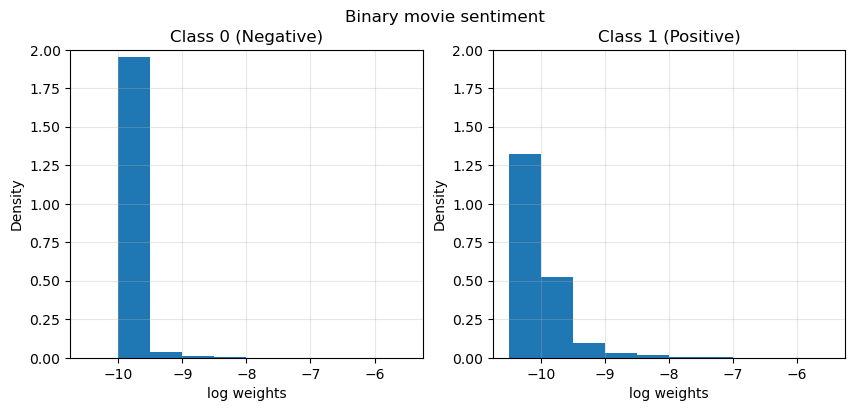

In [13]:
feat_probs = model_0.feature_log_prob_

feats_seeds = [feats_0, feats_1]
dict_labes = {0: 'Negative', 1: 'Positive'}
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Binary movie sentiment")
for i in range(2):
    axes[i].hist(feats_seeds[i], density=True, bins=np.arange(-10.5, -5, 0.5))
    axes[i].set_title(f"Class {i} ({dict_labes[i]})")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(0, 2)
    axes[i].set_ylabel("Density")
    axes[i].set_xlabel("log weights")

#plt.savefig("conditional_probabilities_binary_movie_sentiment.png", format="png", bbox_inches="tight")

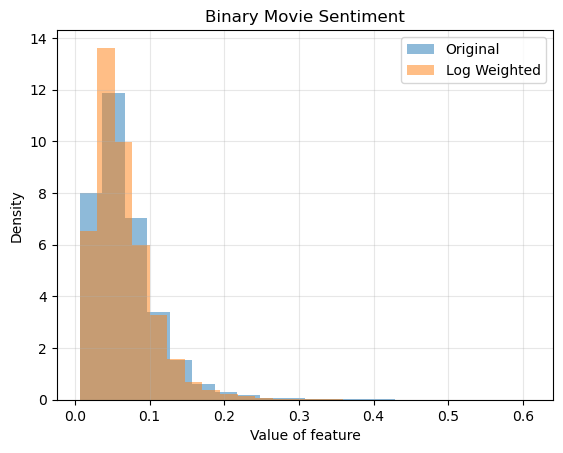

In [70]:
# Example with sparse matrix X
X_log_weighted = np.log1p(X.toarray())  # Apply log(1+x)
flat_x = X.toarray().reshape(1, X.shape[0]*X.shape[1])
non_zero_x = flat_x[flat_x!=0]
log_non_zero_x = np.log1p(non_zero_x)

fig, ax = plt.subplots(1, 1)

bins = 20
# Compare histograms of a sample feature#
ax.grid(alpha=0.3)
v_non_zero, b_non_zeros, _ = ax.hist(non_zero_x, alpha=0.5, label="Original", bins = bins, density=True)
v_log_non_zero, b_log_non_zeros, _ = ax.hist(log_non_zero_x, alpha=0.5, label="Log Weighted", bins=bins, density=True)
ax.set_ylabel("Density")
ax.set_xlabel("Value of feature")
ax.legend()
ax.set_title("Binary Movie Sentiment")

plt.savefig("dist_log_and_original_movie_sentiment.png", format="png", bbox_inches="tight")


In [69]:
mean1 = v_non_zero.mean()
mean2 = v_log_non_zero.mean()
sigma1 = (v_non_zero.std()/np.sqrt(len(v_non_zero)))**2
sigma2 = (v_log_non_zero.std()/np.sqrt(len(v_log_non_zero)))**2

Z = (mean2-mean1)/np.sqrt(sigma1+sigma2)
Z

0.42146260137423014

In [14]:
raw_dataset = {}

task = "binary_abuse"
#task = "binary_movie_sentiment"

balanced_train = False
balanced_eval = True

if balanced_train is False:
    if task == 'binary_movie_sentiment' :
        random.seed(seed)
        filename = f'{data_dir}/{task}/unbalanced_data/{task}_train.csv'
        n = sum(1 for line in open(filename)) - 1
        skip = sorted(random.sample(range(1, n + 1), n - n_train))
        df = pd.read_csv(filename, skiprows=skip)
        raw_dataset['train'], n_classes_train = convert_labels(df)
    else:
        raw_dataset['train'], n_classes_train = convert_labels(load_n_samples(data_dir, task, 'train', n_train,
                                                                                seed=seed))
else:
    raw_dataset['train'], n_classes_train = convert_labels(load_balanced_n_samples(data_dir, task, 'train', 
                                                                                    n_train, seed=seed))
balanced_eval_suffix = 'balanced_' if balanced_eval else 'unbalanced_'
final_eval_set = balanced_eval_suffix + eval_set
raw_dataset['eval'], n_classes_eval = convert_labels(load_n_samples(data_dir, task, final_eval_set, n_eval))

seeds = range(3)

eval_texts = raw_dataset['eval'].text
eval_labels = raw_dataset['eval'].label

results0 = []
results1 = []
results2 = []
results3 = []

feats_0 = np.array([])
feats_1 = np.array([])

balanced_train = 'unbalanced'
balanced_eval = 'balanced'

for seed in seeds:

    model_str = 'MultinomialNB'
    train_texts = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_0 = TfidfVectorizer()
    X = vec_0.fit_transform(train_texts)
    model_0 = MultinomialNB()
    model_0.fit(X, train_labels)
    predictions_0 = model_0.predict(vec_0.transform(eval_texts))

    feats = model_0.feature_log_prob_
    feats_0 = np.concatenate([feats_0, feats[0]])
    feats_1 = np.concatenate([feats_1, feats[1]])


    f1 = f1_score(eval_labels, predictions_0, average='macro', zero_division=0.0)
    results0.append(f1)


    model_str = 'ComplementNB'
    train_texts = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_1 = TfidfVectorizer()
    X = vec_1.fit_transform(train_texts)
    model_1 = ComplementNB()
    model_1.fit(X, train_labels)
    predictions_1 = model_1.predict(vec_1.transform(eval_texts))

    f1 = f1_score(eval_labels, predictions_1, average='macro', zero_division=0.0)
    results1.append(f1)

    model_str = 'MultinomialNB+log'
    train_texts = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_2 = TfidfVectorizer()
    X = vec_2.fit_transform(train_texts)
    X = np.log1p(X)
    model_2 = MultinomialNB()
    model_2.fit(X, train_labels)
    predictions_2 = model_2.predict(np.log1p(vec_2.transform(eval_texts)))

    f1 = f1_score(eval_labels, predictions_2, average='macro', zero_division=0.0)
    results2.append(f1)

    model_str = 'ComplementNB+log'
    train_texts = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].text.values  
    train_labels = data_dict_binary_abuse[task][model_str][balanced_train][balanced_eval][f'seed_{seed}'].label.values

    vec_3 = TfidfVectorizer()
    X = vec_3.fit_transform(train_texts)
    X = np.log1p(X)
    model_3 = ComplementNB()
    model_3.fit(X, train_labels)
    predictions_3 = model_3.predict(np.log1p(vec_3.transform(eval_texts)))

    f1 = f1_score(eval_labels, predictions_3, average='macro', zero_division=0.0)
    results3.append(f1)

results0, results1, results2, results3


([0.3409637755248486, 0.3400149292346848, 0.3381130053263806],
 [0.49145728869556016, 0.5089119907433861, 0.4923618126713811],
 [0.3352494835531543, 0.3342921246037781, 0.3352494835531543],
 [0.4667804951768827, 0.47884456801314323, 0.46531647659080827])

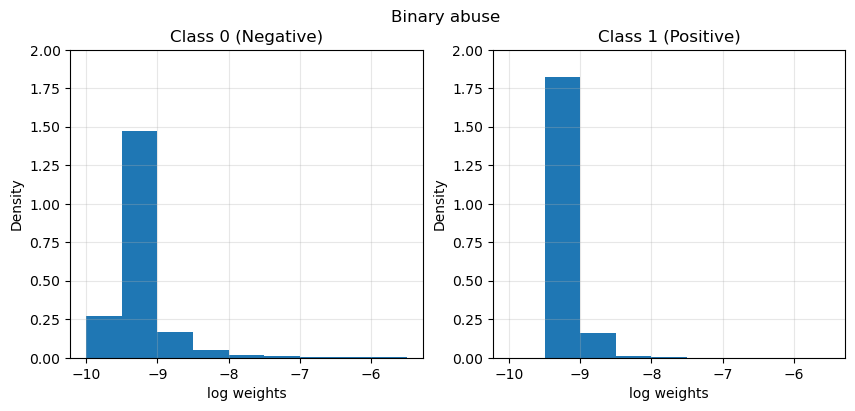

In [15]:
feat_probs = model_0.feature_log_prob_

feats_seeds = [feats_0, feats_1]
dict_labes = {0: 'Negative', 1: 'Positive'}
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Binary abuse")
for i in range(2):
    axes[i].hist(feats_seeds[i], density=True, bins=np.arange(-10., -5, 0.5))
    axes[i].set_title(f"Class {i} ({dict_labes[i]})")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(0, 2)
    axes[i].set_ylabel("Density")
    axes[i].set_xlabel("log weights")

plt.savefig("conditional_probabilities_binary_movie_abuse.png", format="png", bbox_inches="tight")

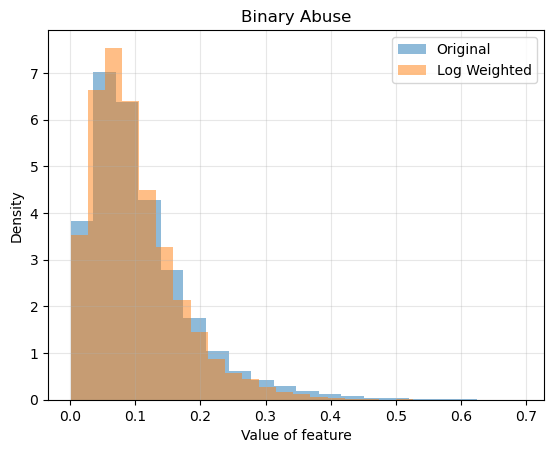

In [66]:
# Example with sparse matrix X
X_log_weighted = np.log1p(X.toarray())  # Apply log(1+x)
flat_x = X.toarray().reshape(1, X.shape[0]*X.shape[1])
non_zero_x = flat_x[flat_x!=0]
log_non_zero_x = np.log1p(non_zero_x)

fig, ax = plt.subplots(1, 1)

bins = 20
# Compare histograms of a sample feature#
ax.grid(alpha=0.3)
v_non_zero, b_non_zeros, _ = ax.hist(non_zero_x, alpha=0.5, label="Original", bins = bins, density=True)
v_log_non_zero, b_log_non_zeros, _ = ax.hist(log_non_zero_x, alpha=0.5, label="Log Weighted", bins=bins, density=True)
ax.set_ylabel("Density")
ax.set_xlabel("Value of feature")
ax.legend()
ax.set_title("Binary Abuse")

plt.savefig("dist_log_and_original_binary_abuse.png", format="png", bbox_inches="tight")


In [54]:
mean1 = v_non_zero.mean()
mean2 = v_log_non_zero.mean()
sigma1 = (v_non_zero.std()/np.sqrt(len(v_non_zero)))**2
sigma2 = (v_log_non_zero.std()/np.sqrt(len(v_log_non_zero)))**2

Z = (mean2-mean1)/np.sqrt(sigma1+sigma2)
Z

0.6252870204624544

In [38]:
2**2

4

In [19]:
X.shape[0]*X.shape[1]

9787392

In [20]:
diffs = (X.toarray()-X_log_weighted).reshape(1, X.shape[0]*X.shape[1])

In [21]:
diffs[diffs != 0]

array([0.00269553, 0.00198744, 0.00983256, ..., 0.0170423 , 0.01779997,
       0.0032764 ])

In [34]:
len(diffs[diffs == 0])#/diffs.shape[1]

9741902

In [30]:
diffs.shape

(1, 9787392)

In [33]:
x = X.toarray().reshape(1, X.shape[0]*X.shape[1])
len(x[x==0])

9741902